# Initialize Notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm, Normalize
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
import matplotlib.patheffects as pe
from mpl_toolkits.mplot3d import Axes3D
import ROOT
import uproot
import os
import sys
import copy
import tqdm
import pandas as pd
import pickle as pkl
from sklearn.decomposition import PCA

%jsroot on
# %matplotlib qt
%matplotlib inline

Welcome to JupyROOT 6.30/02


In [2]:
sys.path.append('../python/')
from filterMethods import *
from gridMethods import *
# from trackReconstructionMethods import *
from hitAccuracyMethods import *
from statisticsMethods import *
from importMethods import *
from constants import *
import plotParameters

In [3]:
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

# Load Data

In [4]:
# fileName = '../runs/event_2mu100MeVBackToBack_usedForTrackReconstruction.root'
fileName = '../build/event.root'
histDir = '/photoSensor_hits_histograms'
print(get_histogram_names    (fileName, histDir))
print(get_histogram_titles   (fileName, histDir))
print(get_histogram_positions(fileName, histDir))
print(get_histogram_walls    (fileName, histDir))

['photoSensor_0;1', 'photoSensor_1;1', 'photoSensor_2;1', 'photoSensor_3;1', 'photoSensor_4;1', 'photoSensor_5;1', 'photoSensor_6;1', 'photoSensor_7;1', 'photoSensor_8;1', 'photoSensor_9;1', 'photoSensor_10;1', 'photoSensor_11;1', 'photoSensor_12;1', 'photoSensor_13;1', 'photoSensor_14;1', 'photoSensor_15;1', 'photoSensor_16;1', 'photoSensor_17;1', 'photoSensor_18;1', 'photoSensor_19;1', 'photoSensor_20;1', 'photoSensor_21;1', 'photoSensor_22;1', 'photoSensor_23;1', 'photoSensor_24;1', 'photoSensor_25;1', 'photoSensor_26;1', 'photoSensor_27;1', 'photoSensor_28;1', 'photoSensor_29;1', 'photoSensor_30;1', 'photoSensor_31;1', 'photoSensor_32;1', 'photoSensor_33;1', 'photoSensor_34;1', 'photoSensor_35;1', 'photoSensor_36;1', 'photoSensor_37;1', 'photoSensor_38;1', 'photoSensor_39;1', 'photoSensor_40;1', 'photoSensor_41;1', 'photoSensor_42;1', 'photoSensor_43;1', 'photoSensor_44;1', 'photoSensor_45;1', 'photoSensor_46;1', 'photoSensor_47;1', 'photoSensor_48;1', 'photoSensor_49;1', 'photoSen

['/DSPD_+x_1384.704220_1120.000000_-1120.000000_0_photoSensor_surface_sensitiveDetector', '/DSPD_+x_1384.704220_960.000000_-1120.000000_1_photoSensor_surface_sensitiveDetector', '/DSPD_+x_1384.704220_800.000000_-1120.000000_2_photoSensor_surface_sensitiveDetector', '/DSPD_+x_1384.704220_640.000000_-1120.000000_3_photoSensor_surface_sensitiveDetector', '/DSPD_+x_1384.704220_480.000000_-1120.000000_4_photoSensor_surface_sensitiveDetector', '/DSPD_+x_1384.704220_320.000000_-1120.000000_5_photoSensor_surface_sensitiveDetector', '/DSPD_+x_1384.704220_160.000000_-1120.000000_6_photoSensor_surface_sensitiveDetector', '/DSPD_+x_1384.704220_0.000000_-1120.000000_7_photoSensor_surface_sensitiveDetector', '/DSPD_+x_1384.704220_-160.000000_-1120.000000_8_photoSensor_surface_sensitiveDetector', '/DSPD_+x_1384.704220_-320.000000_-1120.000000_9_photoSensor_surface_sensitiveDetector', '/DSPD_+x_1384.704220_-480.000000_-1120.000000_10_photoSensor_surface_sensitiveDetector', '/DSPD_+x_1384.704220_-640.0

In [5]:
treeName = 'photoSensor_hits;1'
df_hits = pd.DataFrame(columns=['sensor_name', 'sensor_direction', 'sensor_position', 'relativePosition', 'relativePosition_binned', 'time'])
df_hits['sensor_name'            ] = get_photosensor_hits_photosensor_ID          (fileName, treeName)
df_hits['sensor_direction'       ] = get_photosensor_hits_photosensor_direction   (fileName, treeName)
df_hits['sensor_position'        ] = get_photosensor_hits_photosensor_position    (fileName, treeName)
df_hits['relativePosition'       ] = get_photosensor_hits_position_relative       (fileName, treeName)
df_hits['relativePosition_binned'] = get_photosensor_hits_position_relative_binned(fileName, treeName, histDir)
df_hits['relativePosition_nBin'  ] = get_photosensor_hits_position_relative_nBin  (fileName, treeName, histDir)
df_hits['initialPosition'        ] = get_photosensor_hits_position_initial        (fileName, treeName)
df_hits['time'                   ] = get_photosensor_hits_time                    (fileName, treeName)
print('df_hits length:', len(df_hits))

df_hits length: 27611


In [6]:
treeName = 'primary;1'
df_primary = pd.DataFrame(columns=['position', 'time'])
df_primary['position'] = get_primary_position(fileName, treeName)
df_primary['time'    ] = get_primary_time    (fileName, treeName)
print('df_primary length:', len(df_primary))

df_primary length: 154


# Filter Hits

In [7]:
search_radius = 0
search_number = 0

df_hits = filter_hits(df_hits, radius=search_radius, number=search_number)

# Basic Hit Reco

In [8]:
def rToTheta(r):
    return r/(CM_PER_RAD*MM_PER_CM)
df_hits = make_r(df_hits)
df_hits = filter_r(df_hits, Y_LIM)
df_hits = make_theta(df_hits, rToTheta)
df_hits = make_phi(df_hits)
df_hits = make_reconstructedVector_direction(df_hits)
df_hits = make_relativeVector(df_hits)  
df_hits['time'] /= 10
df_hits = make_reconstructedPoint_time(df_hits, lensDistance=30*10)

In [9]:
# from scipy import stats

# fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# ax[0].hist(df_hits['time'], bins=100)
# ax[0].set_yscale('log')
# ax[0].set_xlabel('time [ns]')

# df_hits = df_hits[np.abs(stats.zscore(df_hits['time'])) < 5]
# ax[1].hist(df_hits['time'], bins=100)
# ax[1].set_yscale('log')
# ax[1].set_xlabel('time [ns]')

# fig.show()

# Plotting Methods

In [10]:
color_oranges = cm.Blues_r  ([0.5,0.6,0.9])
color_blues   = cm.Oranges_r([0.5,0.6,0.9])
blue_1 = "#B6CEC7"
blue_2 = "#92C1A5"
blue_3 = "#889D8E"
red_1  = "#C16464"
red_2  = "#B64D4D"
red_3  = "#FBE6E5"
twilight = cm.twilight(np.linspace(0,1,40))

In [11]:
primary_true = np.array(df_primary['position'].to_list()).reshape(-1,3)
primary_true = primary_true[np.where((primary_true[:, 0] <  DETECTOR_SIZE_MM[0]/2) & (primary_true[:, 1] < DETECTOR_SIZE_MM[1]/2) & (primary_true[:, 2] < DETECTOR_SIZE_MM[2]/2) & 
                                     (primary_true[:, 0] > -DETECTOR_SIZE_MM[0]/2) & (primary_true[:, 1] > -DETECTOR_SIZE_MM[1]/2) & (primary_true[:, 2] > -DETECTOR_SIZE_MM[2]/2))]
# primary_true = primary_true[np.where((primary_true[:, 0] < np.max(X_mean[:,0])) & (primary_true[:, 1] < np.max(X_mean[:,1])) & (primary_true[:, 2] < np.max(X_mean[:,2]))
#                                    & (primary_true[:, 0] > np.min(X_mean[:,0])) & (primary_true[:, 1] > np.min(X_mean[:,1])) & (primary_true[:, 2] > np.min(X_mean[:,2])))]

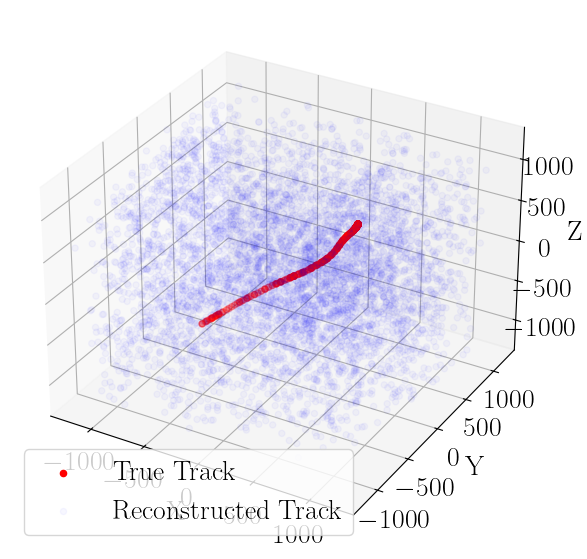

In [12]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(primary_true[:,0], primary_true[:,1], primary_true[:,2], color='red', label='True Track')
recoPoints = np.array(df_hits['reconstructedPoint_time'].to_list()).reshape(-1,3)
recoPoints = recoPoints[np.where((recoPoints[:, 0] <  DETECTOR_SIZE_MM[0]/2) & (recoPoints[:, 1] <  DETECTOR_SIZE_MM[1]/2) & (recoPoints[:, 2] <  DETECTOR_SIZE_MM[2]/2) &
                                 (recoPoints[:, 0] > -DETECTOR_SIZE_MM[0]/2) & (recoPoints[:, 1] > -DETECTOR_SIZE_MM[1]/2) & (recoPoints[:, 2] > -DETECTOR_SIZE_MM[2]/2))]
ax.scatter(recoPoints[:,0], recoPoints[:,1], recoPoints[:,2], color='blue', label='Reconstructed Track', alpha=0.03)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.legend()

plt.show()
